# Sentiment Analysis

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/LSTM_CNN_image.png
/kaggle/input/images/CNN-LSTM_image.png
/kaggle/input/images/CNNs.png
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


### load needed libraries

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
import os
from IPython.display import Image

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
#from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#import transformers
#import tokenizers

### load our data

In [6]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df= data.copy()

### Data preprocessing

In [7]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
data.shape

(50000, 2)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [10]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [11]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Data Cleaning

In [12]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [13]:
 data.duplicated().sum()

418

In [14]:
data.drop_duplicates(inplace = True)

In [15]:
data.shape

(49582, 2)

In [16]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [17]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

In [18]:
#function to clean data

import nltk
nltk.download('wordnet')
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
data['review']=data['review'].apply(clean_text,lemmatize = True)

In [20]:
#converting target variable to numeric labels
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1


#### Spliting the training dataset


In [21]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)

#train dataset
Xtrain, ytrain = train['review'], train['sentiment']

#test dataset
Xtest, ytest = test['review'], test['sentiment']

print(Xtrain.shape,ytrain.shape)
print(Xtest.shape,ytest.shape)

(39665,) (39665,)
(9917,) (9917,)


#### Vectorizing data




In [22]:
vect = TfidfVectorizer()
Xtrain_vect= vect.fit_transform(Xtrain)
Xtest_vect = vect.transform(Xtest)


count_vect = CountVectorizer() 
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

# 1- LSTM model

In [23]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  126096


In [24]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [25]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [26]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [27]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.51 % of data


In [28]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [29]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [30]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [31]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----


2021-12-11 12:30:36.113461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 12:30:36.244517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 12:30:36.245221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 12:30:36.247175: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 293)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 293, 64)           8070208   
_________________________________________________________________
batch_normalization (BatchNo (None, 293, 64)           256       
_________________________________________________________________
dropout (Dropout)            (None, 293, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 289, 32)           10272     
_________________________________________________________________
dropout_1 (Dropout)          (None, 289, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 144, 32)           0     

2021-12-11 12:30:39.662167: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-11 12:30:44.411697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


992/992 - 38s - loss: 0.4254 - accuracy: 0.7934 - val_loss: 0.2836 - val_accuracy: 0.8881
Epoch 2/5
992/992 - 25s - loss: 0.2469 - accuracy: 0.9017 - val_loss: 0.2798 - val_accuracy: 0.8925
Epoch 3/5
992/992 - 25s - loss: 0.1952 - accuracy: 0.9261 - val_loss: 0.2882 - val_accuracy: 0.8910
Epoch 4/5
992/992 - 25s - loss: 0.1497 - accuracy: 0.9465 - val_loss: 0.3353 - val_accuracy: 0.8834
Epoch 5/5
992/992 - 26s - loss: 0.1110 - accuracy: 0.9598 - val_loss: 0.3840 - val_accuracy: 0.8858
992/992 [==============================] - 9s 9ms/step - loss: 0.0398 - accuracy: 0.9887
Train score: [0.03976896405220032, 0.9886865019798279]
248/248 [==============================] - 2s 9ms/step - loss: 0.3840 - accuracy: 0.8858
Validation score: [0.38402771949768066, 0.8857935070991516]


In [32]:
def plotLearningCurve(history,epochs):
    
    epochRange = range(1,epochs+1)
    fig , ax = plt.subplots(1,2,figsize = (10,5))
  
    ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
    ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    fig.tight_layout()
    plt.show()

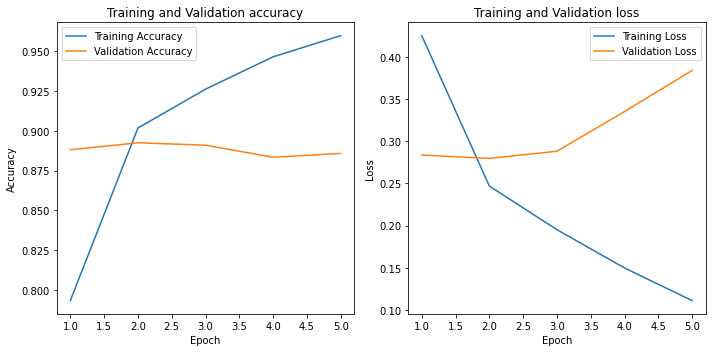

In [33]:
plotLearningCurve(r,n_epochs)

In [34]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 3s 9ms/step - loss: 0.4140 - accuracy: 0.8783
{'loss': 0.4140194058418274, 'accuracy': 0.8782898187637329}


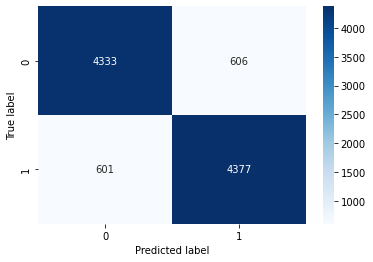

In [35]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 2-CNN model

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn import datasets

from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, MaxPool1D, Dropout, SimpleRNN, LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
import numpy as np
import string
import re

In [37]:
df.sentiment = df.sentiment.map({ 'negative': 0, 'positive': 1 })

text = df.review.tolist()
label = df.sentiment.tolist()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=1)

In [39]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space

In [40]:
X_train_clean = []
X_test_clean = []
clean = re.compile(r'<[^>]+>')
for i, test in enumerate(X_train):
    tmp_text = test.lower()
    tmp_text = tmp_text.replace('\n', '')
    tmp_text = clean.sub('', tmp_text)
    tmp_text = tmp_text.translate(translator)
    X_train_clean.append(tmp_text)

for i, test in enumerate(X_test):
    tmp_text = test.lower()
    tmp_text = tmp_text.replace('\n', '')
    tmp_text = clean.sub('', tmp_text)
    tmp_text = tmp_text.translate(translator)
    X_test_clean.append(tmp_text)

X_train_clean = np.array(X_train_clean)
X_test_clean = np.array(X_test_clean)

X_train = X_train_clean
X_test = X_test_clean

In [41]:
top_words = 40000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
max_words = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_words, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=max_words, padding='post')

In [43]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [44]:
X_train.shape


(40000, 100)

In [45]:
model = Sequential()
model.add(Embedding(20000,32, input_length=100))
model.add(Conv1D(256, 3, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 256)          24832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25, 128)           0

In [47]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=128, verbose=2)

Epoch 1/20
313/313 - 3s - loss: 0.4584 - accuracy: 0.7419 - val_loss: 0.2950 - val_accuracy: 0.8756
Epoch 2/20
313/313 - 2s - loss: 0.2383 - accuracy: 0.9036 - val_loss: 0.2883 - val_accuracy: 0.8790
Epoch 3/20
313/313 - 2s - loss: 0.1585 - accuracy: 0.9403 - val_loss: 0.3281 - val_accuracy: 0.8712
Epoch 4/20
313/313 - 2s - loss: 0.0952 - accuracy: 0.9664 - val_loss: 0.3866 - val_accuracy: 0.8669
Epoch 5/20
313/313 - 2s - loss: 0.0579 - accuracy: 0.9799 - val_loss: 0.5340 - val_accuracy: 0.8638
Epoch 6/20
313/313 - 2s - loss: 0.0358 - accuracy: 0.9874 - val_loss: 0.6599 - val_accuracy: 0.8565
Epoch 7/20
313/313 - 2s - loss: 0.0270 - accuracy: 0.9903 - val_loss: 0.6674 - val_accuracy: 0.8554
Epoch 8/20
313/313 - 2s - loss: 0.0216 - accuracy: 0.9923 - val_loss: 0.8906 - val_accuracy: 0.8489
Epoch 9/20
313/313 - 2s - loss: 0.0168 - accuracy: 0.9941 - val_loss: 0.8887 - val_accuracy: 0.8514
Epoch 10/20
313/313 - 2s - loss: 0.0162 - accuracy: 0.9945 - val_loss: 0.9318 - val_accuracy: 0.8514

In [48]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(X_test,y_test)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
313/313 [==============================] - 1s 2ms/step - loss: 1.2129 - accuracy: 0.8506
{'loss': 1.2128911018371582, 'accuracy': 0.850600004196167}


# 3- LSTM-CNN Model

In [49]:
model = Sequential()
model.add(Embedding(20000,32, input_length=100))
model.add(Conv1D(256, 3, activation='relu', input_shape=(178, 1), padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           640000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 256)          24832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 50, 128)           98432     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 128)          

In [51]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=128, verbose=2)

Epoch 1/20
313/313 - 7s - loss: 0.4356 - accuracy: 0.7802 - val_loss: 0.2968 - val_accuracy: 0.8702
Epoch 2/20
313/313 - 3s - loss: 0.2408 - accuracy: 0.9042 - val_loss: 0.2944 - val_accuracy: 0.8722
Epoch 3/20
313/313 - 3s - loss: 0.1623 - accuracy: 0.9403 - val_loss: 0.3486 - val_accuracy: 0.8673
Epoch 4/20
313/313 - 3s - loss: 0.1020 - accuracy: 0.9648 - val_loss: 0.4109 - val_accuracy: 0.8635
Epoch 5/20
313/313 - 3s - loss: 0.0620 - accuracy: 0.9800 - val_loss: 0.4801 - val_accuracy: 0.8623
Epoch 6/20
313/313 - 3s - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.5834 - val_accuracy: 0.8568
Epoch 7/20
313/313 - 3s - loss: 0.0349 - accuracy: 0.9880 - val_loss: 0.6256 - val_accuracy: 0.8469
Epoch 8/20
313/313 - 3s - loss: 0.0230 - accuracy: 0.9932 - val_loss: 0.7052 - val_accuracy: 0.8519
Epoch 9/20
313/313 - 3s - loss: 0.0240 - accuracy: 0.9919 - val_loss: 0.6855 - val_accuracy: 0.8501
Epoch 10/20
313/313 - 3s - loss: 0.0174 - accuracy: 0.9943 - val_loss: 0.6710 - val_accuracy: 0.8498

In [52]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(X_test,y_test)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
313/313 [==============================] - 1s 4ms/step - loss: 0.9500 - accuracy: 0.8518
{'loss': 0.9499828219413757, 'accuracy': 0.8518000245094299}


# Sources

- http://konukoii.com/blog/2018/02/19/twitter-sentiment-analysis-using-combined-lstm-cnn-models/
- https://arxiv.org/pdf/1408.5882.pdf
- https://github.com/pytorch/ignite/blob/master/examples/notebooks/TextCNN.ipynb
- https://www.kaggle.com/raghav2002sharma/sentiment-classifier-with-cnn-bi-lstm
- https://www.kaggle.com/ashrafkhan94/imdb-review-comparison-using-cnn-lstm-bert
- https://www.kaggle.com/parth05rohilla/bi-lstm-and-cnn-model-top-10/notebook
- https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/code?competitionId=10025&searchQuery=cnn
- https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_natural-language-processing-applications/sentiment-analysis-cnn.ipynb
- https://www.kaggle.com/nafisur/keras-models-lstm-cnn-gru-bidirectional-glove
- https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#5.-Predictive-Modelling-using-Deep-Learning
- https://www.kaggle.com/clementbrehard/imdb-conv1d-lstm